# Task : Analyzing and clustering

### *Using Transaction Data*

*Rabbani Zahid Mahdi Tanra*

---

A simple yet powerful marketing technique is an analysis utilizing _recency_ (how recent was the customer's last purchase), _frequency_ (how often did the customer make a purchase in a given period) and _monetary_ (how much money did the customer spend in a given period) data to identify the best customers and perform targeted marketing campaigns. 

As data scientist you are asked to segment the customers using transaction data and profile them based-on their characteristics (recency, frequency, monetary). After you find the segments, name them using understandable words so marketing team can easily create campaign strategies.

**Data:**
`../data/transactions.csv`

**Hints:** 
For each customer id, generate time difference between their last transaction and today. You should also calculate number of transaction and total amount of spending. You are allowed to use SQL.

**Output:**
Push the *executed* notebook into your github repo and submit the URL to ketua kelas no later than August 21, 2021. Note that notebook must contain explanatory analysis and clustering as well as story about your findings.

**Goodluck!**

---

## 1. Load Libraries

In [221]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
import os
warnings.filterwarnings("ignore")

py.offline.init_notebook_mode(connected = True)

## 2. Data Exploration

In [222]:
df = pd.read_csv(r'../data/transactions.csv')
df.head()

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78


In [223]:
df.shape

(125000, 3)

In [224]:
print(df.loc[[6037]])

     customer_id trans_date  trans_amount
6037      CS5930  29-Feb-17            68


In [225]:
df.isna().sum()

customer_id     0
trans_date      0
trans_amount    0
dtype: int64

In [226]:
df.dtypes

customer_id     object
trans_date      object
trans_amount     int64
dtype: object

In [227]:
df['trans_date'] = df['trans_date'].astype('str')
df.dtypes

customer_id     object
trans_date      object
trans_amount     int64
dtype: object

In [228]:
df['trans_date'] = df['trans_date'].map(lambda x: x.lstrip('[]\'').rstrip('[]\''))
df.head()

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78


In [229]:
df['trans_date'] = pd.to_datetime(df['trans_date'], format='%d-%b-%y',errors='coerce')

In [230]:
df.isna().sum()

customer_id      0
trans_date      90
trans_amount     0
dtype: int64

In [231]:
df.dropna(axis = 0, inplace = True)

In [232]:
df.isna().sum()

customer_id     0
trans_date      0
trans_amount    0
dtype: int64

In [233]:
df.shape

(124910, 3)

In [234]:
df.describe()

,trans_amount
count,124910.00000
mean,64.99105
std,22.86131
min,10.00000
25%,47.00000
50%,65.00000
75%,83.00000
max,105.00000


### date difference between today (6 August 2021)

In [235]:
grouping = df.groupby(['customer_id'])
df_max_date = grouping.agg(latest_trans=('trans_date', np.max))

In [236]:
cur_date = pd.to_datetime('2021/08/06', format='%Y/%m/%d')
df_max_date['diffdate'] = cur_date - df_max_date['latest_trans']

In [237]:
df_max_date.head()

,latest_trans,diffdate
customer_id,,
CS1112,2020-01-14,570 days
CS1113,2020-02-09,544 days
CS1114,2020-02-12,541 days
CS1115,2020-03-05,519 days
CS1116,2019-08-25,712 days


In [238]:
df_max_date.shape

(6889, 2)

### groupby customer count transaction and sum total amount

In [239]:
grouping = df.groupby(['customer_id'])
trans_customer = grouping.agg(total_trans=('trans_amount', np.count_nonzero), tot_amount = ('trans_amount',np.sum))

In [240]:
trans_customer.head()

,total_trans,tot_amount
customer_id,,
CS1112,15,1012
CS1113,20,1490
CS1114,19,1432
CS1115,22,1659
CS1116,13,857


In [241]:
trans_customer.shape

(6889, 2)

In [242]:
data_prep = pd.concat([df_max_date,trans_customer],axis=1)
data_prep.reset_index(level=0, inplace=True)
data_prep['diffdate'] = data_prep.apply(lambda row: row.diffdate.days, axis=1)
data_prep.head()

,customer_id,latest_trans,diffdate,total_trans,tot_amount
0,CS1112,2020-01-14,570,15,1012
1,CS1113,2020-02-09,544,20,1490
2,CS1114,2020-02-12,541,19,1432
3,CS1115,2020-03-05,519,22,1659
4,CS1116,2019-08-25,712,13,857


In [243]:
data_prep.describe()

,diffdate,total_trans,tot_amount
count,6889.000000,6889.000000,6889.000000
mean,589.349252,18.131804,1178.404993
std,85.545443,5.192020,465.605801
min,508.000000,4.000000,149.000000
25%,531.000000,14.000000,781.000000
50%,562.000000,18.000000,1227.000000
75%,620.000000,22.000000,1520.000000
max,1366.000000,39.000000,2933.000000


## 3. Data Visualization 

In [244]:
plt.style.use('seaborn')

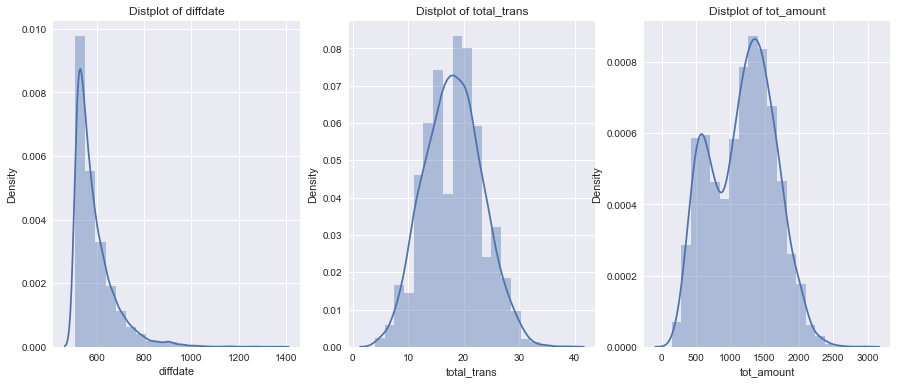

In [245]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['diffdate' , 'total_trans' , 'tot_amount']:
    n += 1
    plt.subplot(1 , 3 , n)
    sns.distplot(data_prep[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

## 4. Standardized Variable (Optional but Strongly Recommended)

In [246]:
X = data_prep.drop(['customer_id','latest_trans'], axis=1)

standardize = StandardScaler()
X_std = pd.DataFrame(standardize.fit_transform(X))
X_std.columns = X.columns
X_std.describe()

,diffdate,total_trans,tot_amount
count,6.889000e+03,6.889000e+03,6.889000e+03
mean,-3.980784e-16,4.744709e-15,2.001592e-16
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-9.510168e-01,-2.722029e+00,-2.211054e+00
25%,-6.821344e-01,-7.958567e-01,-8.535844e-01
50%,-3.197276e-01,-2.538779e-02,1.043770e-01
75%,3.583238e-01,7.450812e-01,7.337104e-01
max,9.079468e+00,4.019574e+00,3.768687e+00


## K-Means Clustering

### K-Means: with 2 variables

In [247]:
X_diff_tottrans = X_std[['diffdate','total_trans']].values
X_diff_totamount = X_std[['diffdate','tot_amount']].values
X_tottrans_totamount = X_std[['total_trans','tot_amount']].values

In [248]:
def k_means_inertia_silhouette(X, k_max = 10, init = 'k-means++'):
    inertia = []
    silhouette = []
    for k in range(2, k_max):
        km =  KMeans(init = init, n_clusters = k, random_state= 123)
        km.fit(X)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia for each number of cluster')
    plt.show()

    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score for each number of cluster')
    plt.show()
    
    return inertia, silhouette

### A. K-Means Clustering based on recency - frequency

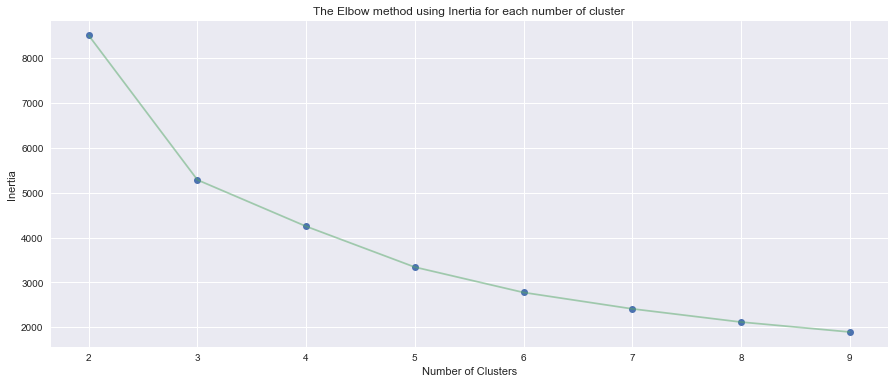

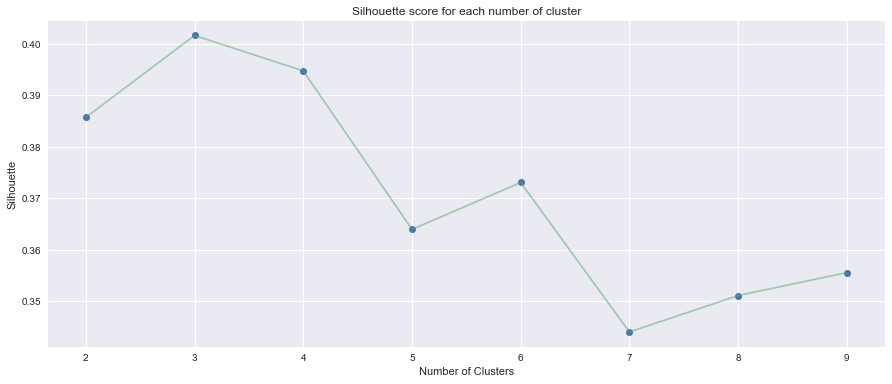

In [249]:
inertia, silhouette = k_means_inertia_silhouette(X = X_diff_tottrans)

In [250]:
k = 3
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means_difftrans = k_means.fit(X_diff_tottrans)
centroids_diff_tottrans = k_means.cluster_centers_
centroids_diff_tottrans

array([[-0.28587986, -0.69772716],
       [-0.3431659 ,  0.88237753],
       [ 1.92769162, -0.73363879]])

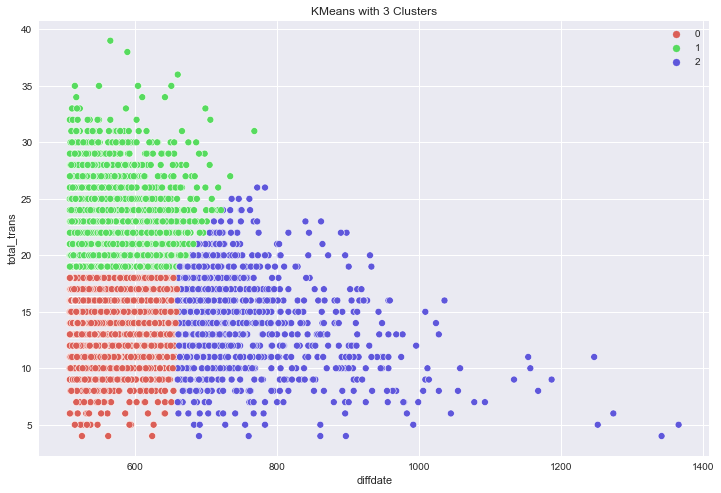

In [251]:
Segment_difftrans = k_means_difftrans.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(X['diffdate'], X['total_trans'], hue=Segment_difftrans,
                palette=sns.color_palette('hls', 3))
plt.title('KMeans with {} Clusters'.format(k))
plt.show()

In [252]:
(unique, counts) = np.unique(Segment_difftrans, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 2855],
       [   1, 3064],
       [   2,  970]], dtype=int64)

*Group : <br>
1 : Regular Customer ( frequency : 4 - 18 transaction, recency : 200 - 640 days) : 2855 Customer <br>
2 : interested Customer ( frequency : more than 18 transaction, recency : 200 - 640 days) : 3064 Customer <br>
3 : Uninterested Customer (recency : older than 640 days) : 970 Customer* 

In [253]:
centroids = X[['diffdate' , 'total_trans']].groupby(Segment_difftrans, as_index=False).mean()
centroids

,diffdate,total_trans
0,564.861996,14.508932
1,559.995104,22.712794
2,754.145361,14.324742


### B. K-Means Clustering based on recency - monetary

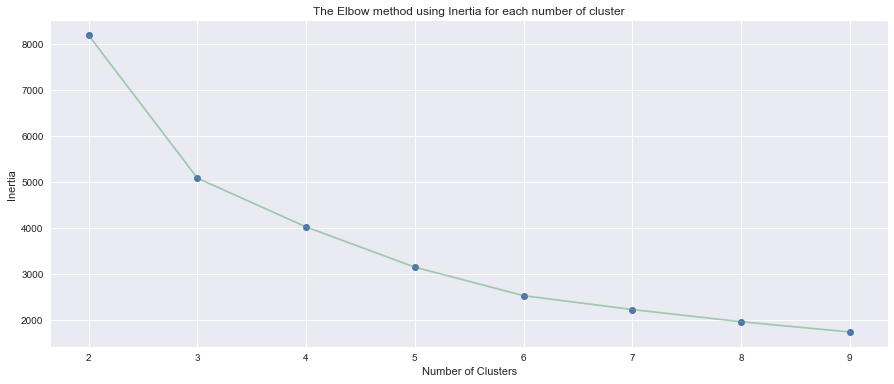

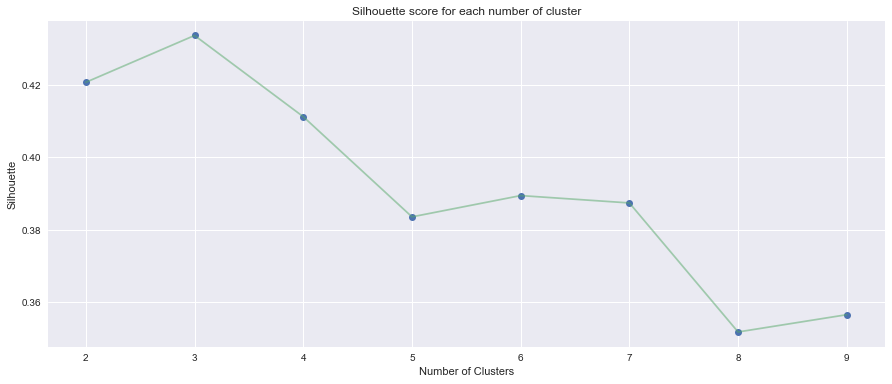

In [254]:
inertia, silhouette = k_means_inertia_silhouette(X = X_diff_totamount)

In [255]:
k = 3
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means_diffamount = k_means.fit(X_diff_totamount)
centroids_diff_totamount = k_means.cluster_centers_

centroids_diff_totamount

array([[-0.33307647,  0.74722916],
       [ 1.9924388 , -0.6770382 ],
       [-0.25774972, -0.94389418]])

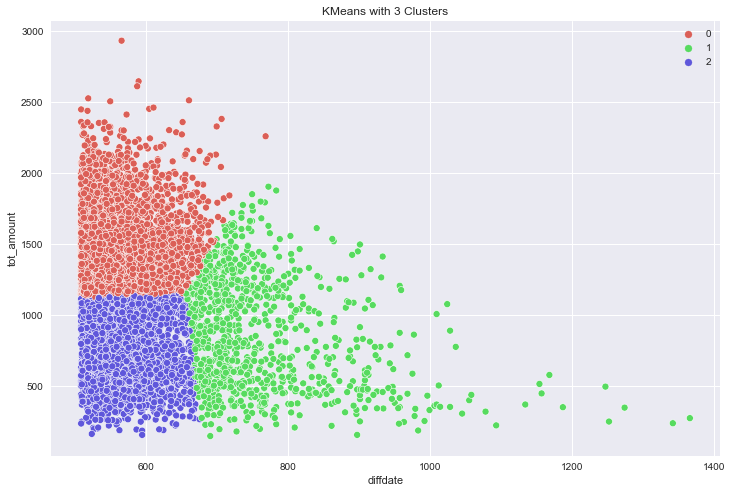

In [256]:
Segment_diffamount = k_means_diffamount.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(X['diffdate'], X['tot_amount'], hue=Segment_diffamount,
                palette=sns.color_palette('hls', 3))
plt.title('KMeans with {} Clusters'.format(k))
plt.show()

In [257]:
(unique, counts) = np.unique(Segment_diffamount, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 3701],
       [   1,  912],
       [   2, 2276]], dtype=int64)

*Group : <br>
1 : High Budget interested Customer ( monetary : more than 1200 dollars spent, recency : 200 - 640 days) : 3701 Customer  <br>
2 : Uninterested Customer (recency : older than 640 days) :  912 Customer <br>
3 : normal budget interested Customer ( monetary : lower than 1200 dollars spent, recency : 200 - 640 days) : 2276 Customer*

In [258]:
centroids = X[['diffdate' , 'tot_amount']].groupby(Segment_diffamount, as_index=False).mean()
centroids

,diffdate,tot_amount
0,560.858146,1526.293975
1,759.888158,863.190789
2,567.343146,739.010545


In [259]:
X['Segment'] = list(map(str, Segment_diffamount))
fig = px.scatter_3d(X, x='diffdate', y='total_trans', z='tot_amount', color='Segment',
                   opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg') 

*Group : <br>
1 : High Budget interested Customer ( monetary : more than 1200 dollars spent, frequency : more than 20 transaction, recency : 200 - 640 days) : 3701 Customer  <br>
2 : Uninterested Customer (recency : older than 640 days) :  912 Customer <br>
3 : normal budget interested Customer ( monetary : lower than 1200 dollars spent, frequency : lower than 20 transaction, recency : 200 - 640 days) : 2276 Customer*

## Hierarchical Clustering: Agglomerative

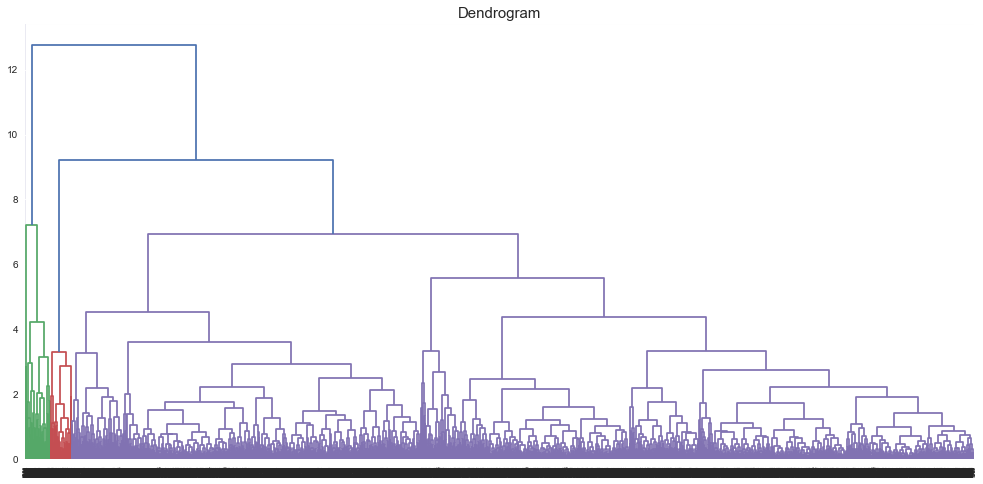

In [260]:
plt.figure(figsize = (17, 8))

dendo = dendrogram(linkage(X_std, method = 'complete'))
plt.title('Dendrogram', fontsize = 15)
plt.show()

In [261]:
agglo_cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'complete')
agg = agglo_cluster.fit(X_std)
Segment_agg = agglo_cluster.fit_predict(X_std)

In [262]:
(unique, counts) = np.unique(Segment_agg, return_counts=True)
np.asarray((unique, counts)).T

array([[   0,  182],
       [   1, 6552],
       [   2,  155]], dtype=int64)

In [263]:
centroids = X.groupby(Segment_agg, as_index=False).mean()
centroids

,diffdate,total_trans,tot_amount
0,910.791209,11.472527,621.472527
1,580.796551,18.030067,1170.822497
2,573.445161,30.251613,2152.870968


In [264]:
X['Segment'] = list(map(str, Segment_agg))
fig = px.scatter_3d(X, x='diffdate', y='total_trans', z='tot_amount', color='Segment',
                   opacity = 0.8, height=800)
fig.show()

*Group : <br>
1 : Uninsterested Customer (recency : older than 800 days, frequency : less than 20 transaction, monetary : lower than 1200 dollars spent) : 182 Customer <br>
2 : Regular Customer (recency : older than 800 days, frequency : less than 30 transaction, monetary : lower than 2000 dollars spent) : 6552 Customer <br>
3 : Interested Customer (recency : older than 800 days, frequency : more than 30 transaction, monetary : more than 1200 dollars spent) :  155 Customer*

## Density-based Clustering : DBSCAN

In [265]:
arr = X_std.to_numpy()

In [266]:
db = DBSCAN(eps=0.25, min_samples=10).fit(arr)

In [267]:
labels = db.labels_ 
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 460


In [268]:
(unique, counts) = np.unique(labels, return_counts=True)
np.asarray((unique, counts)).T

array([[  -1,  460],
       [   0, 6393],
       [   1,   12],
       [   2,   14],
       [   3,   10]], dtype=int64)

### Visualization of DBSCAN

In [269]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
print(core_samples_mask)

[ True  True  True ...  True False  True]


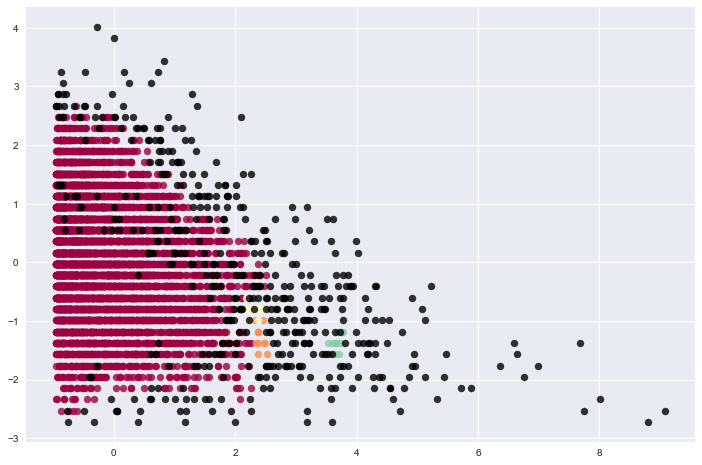

In [270]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))] 

plt.figure(figsize=(12, 8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Plot the datapoints that are clustered
    xy = arr[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.8)

    # Plot the outliers
    xy = arr[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.8)

*Difficult to conclude from the graph, DBSCAN not tsuitable for this data*

## Evaluation K-Means vs Agglomerative Clustering

### K-Means Clustering Score

### A. K-Means Clustering based on recency - frequency

In [271]:
score_kemans_s = silhouette_score(X_diff_tottrans, k_means_difftrans.labels_, metric='euclidean')
print('Silhouette Score: %.4f' % score_kemans_s)

Silhouette Score: 0.4016


### B. K-Means Clustering based on recency - monetary

In [272]:
score_kemans_s = silhouette_score(X_diff_totamount, k_means_diffamount.labels_, metric='euclidean')
print('Silhouette Score: %.4f' % score_kemans_s)

Silhouette Score: 0.4337


## Agglomerative Clustering Score

In [273]:
score_kemans_s = silhouette_score(X_std, agg.labels_, metric='euclidean')
print('Silhouette Score: %.4f' % score_kemans_s)

Silhouette Score: 0.3132


# *Conclusion*

Based on Silhouette Score, I conclude that using K-Means based on recency - monetary describe the data's clustering the most, therefore data can be clustered into 3 group; <br>
<br>
*Group : <br>
1 : High Budget interested Customer ( monetary : more than 1200 dollars spent, frequency : more than 20 transaction, recency : 200 - 640 days) : 3701 Customer  <br>
2 : Uninterested Customer (recency : older than 640 days) :  912 Customer <br>
3 : normal budget interested Customer ( monetary : lower than 1200 dollars spent, frequency : lower than 20 transaction, recency : 200 - 640 days) : 2276 Customer*

In [274]:
X['Segment'] = list(map(str, Segment_diffamount))
fig = px.scatter_3d(X, x='diffdate', y='total_trans', z='tot_amount', color='Segment',
                   opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg') 

*Created by : Rabbani Zahid Mahdi Tanra*